In [1]:
#load modules
print('loading modules...')
import numpy as np
import basic
import pickle
import curvedsky
#import cmb
import healpy as hp
import pymaster as nmt
import matplotlib.pyplot as plt

##########################################################################

import os,sys
import pylab as pl
import numpy as np
import lenspyx
import healpy as hp
sys.path.append('/root/Testarea/prototype/Foreground')
from lensingb_mine import *
from noise_making import *
from utils_mine import *
from phi_noise_making import *
from generate_map import *
from lenspyx.utils import camb_clfile
from lenspyx.utils_hp import synalm, almxfl, alm2cl

camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))    
sys.path.insert(0,camb_path)

import camb
from camb import model, initialpower ,correlations

from scipy.special import factorial

import pymaster as nm
import pickle


loading modules...
loading modules...
loading modules...
loading modules...


# 计算Cl平均值

## 首先，关于LT*LT

In [3]:
#第一遍平均获得各bias项和transfer function
def plot_mean_with_error_bars_from_directory_txt(directory_path, nmax):
    """
    一个bin中的nbl个点为一个样本,求得均值。
    k次模拟对应的该区间k个样本,求得k个均值。这k个均值的统计方差为sigma^2/nbl (sigma为分布标准差)
    (对一组数直接求方差,得到的是分布方差(方差的定义),相当于1个数当成1个样本得一个均值)
    这样可以考虑到在不同区间内数据的变化情况。
    """
    # 用于存储有效多极项和功率谱数组的列表
    ell_eff_list = []
    cl_binned_list = []

    # 获取目录中的所有文件名
    file_names = os.listdir(directory_path)
    NUM = 0 
    data = np.loadtxt(os.path.join(directory_path, file_names[0]))
    # 读取每个文件的数组数据并存储在列表中
    for file_name in file_names:
        #if NUM == 100:
            #continue  # Skip the file at index 100，有问题，不要使用，最后只有499套模拟
        #print(NUM,file_name)
        file_path = os.path.join(directory_path, file_name)
        # 使用 get_binned 函数得到有效多极项和分 bin 后的功率谱数组
        cl_binned = np.loadtxt(file_path)
        #ell_eff = [ 26.5,  76.5, 126.5, 176.5, 226.5, 276.5, 326.5, 376.5, 426.5,
       #476.5, 526.5, 576.5, 626.5, 676.5, 726.5, 776.5, 826.5, 876.5,
       #926.5]
        # 存储到列表中
        #ell_eff_list.append(ell_eff)
        #cl_binned_list.append(cl_binned)
        cl_binned_list.append(cl_binned)
        NUM += 1
        if NUM == nmax:
            break

    # 计算平均值和标准差
    #mean_ell_eff = np.mean(ell_eff_list, axis=0)
    mean_cl_binned = np.mean(cl_binned_list, axis=0)
    std_dev_cl_binned = np.std(cl_binned_list, axis=0)

    # 绘制统计平均值和误差棒
    #plt.errorbar(mean_ell_eff, mean_cl_binned, yerr=std_dev_cl_binned, fmt='.', label='Mean with Error Bars')
    #plt.xlabel('Effective Multipole Moments')
    #plt.ylabel('Binned Power Spectrum')
    #plt.title('Mean and Error Bars of Binned Power Spectrum')
    #plt.legend()
    #plt.semilogy()
    #plt.ylim(1e-3,3e-1)
    #plt.show()

    return mean_cl_binned, std_dev_cl_binned

dlbb_LT_LT_mean,_ = plot_mean_with_error_bars_from_directory_txt('./LT_LT', 500)

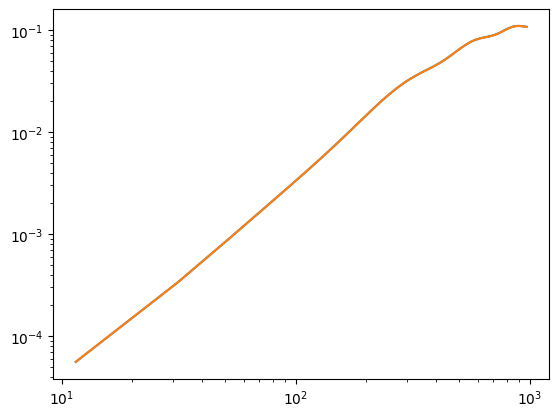

In [4]:
ell_eff = [11.5,  31.5,  51.5,  71.5,  91.5, 111.5, 131.5, 151.5, 171.5, 191.5, 211.5, 231.5,
 251.5, 271.5, 291.5, 311.5, 331.5, 351.5, 371.5, 391.5, 411.5, 431.5, 451.5, 471.5,
 491.5, 511.5, 531.5, 551.5, 571.5, 591.5, 611.5, 631.5, 651.5, 671.5, 691.5, 711.5,
 731.5, 751.5, 771.5, 791.5, 811.5, 831.5, 851.5, 871.5, 891.5, 911.5, 931.5, 951.5,
 971.5,]
plt.loglog(ell_eff,dlbb_LT_LT_mean[5])
plt.loglog(ell_eff,(dlbb_LT_LT_mean[1]-dlbb_LT_LT_mean[2]-2*dlbb_LT_LT_mean[4])/dlbb_LT_LT_mean[6])
#plt.loglog(ell_eff,(dlbb_LT_LT)) 来自下面

In [5]:
np.savetxt('./LT_LT_mean.txt', dlbb_LT_LT_mean)

In [6]:
#第二遍平均获得debiased LT_LT及其标准差
def plot_mean_with_error_bars_from_directory_txt2(directory_path, nmax):
    """
    一个bin中的nbl个点为一个样本,求得均值。
    k次模拟对应的该区间k个样本,求得k个均值。这k个均值的统计方差为sigma^2/nbl (sigma为分布标准差)
    (对一组数直接求方差,得到的是分布方差(方差的定义),相当于1个数当成1个样本得一个均值)
    这样可以考虑到在不同区间内数据的变化情况。
    """
    # 用于存储有效多极项和功率谱数组的列表
    ell_eff_list = []
    cl_binned_list = []

    mean = np.loadtxt('./LT_LT_mean.txt')

    # 获取目录中的所有文件名
    file_names = os.listdir(directory_path)
    NUM = 0 
    data = np.loadtxt(os.path.join(directory_path, file_names[0]))
    # 读取每个文件的数组数据并存储在列表中
    for file_name in file_names:
        print(NUM,file_name)
        file_path = os.path.join(directory_path, file_name)
        # 使用 get_binned 函数得到有效多极项和分 bin 后的功率谱数组
        cl_binned = np.loadtxt(file_path)
        #ell_eff = [ 26.5,  76.5, 126.5, 176.5, 226.5, 276.5, 326.5, 376.5, 426.5,
       #476.5, 526.5, 576.5, 626.5, 676.5, 726.5, 776.5, 826.5, 876.5,
       #926.5]
        # 存储到列表中
        #ell_eff_list.append(ell_eff)
        #cl_binned_list.append(cl_binned)
        cl_binned_list.append((cl_binned[1] - mean[2] - 2*mean[4])/mean[6])
        NUM += 1
        if NUM == nmax:
            break

    # 计算平均值和标准差
    #mean_ell_eff = np.mean(ell_eff_list, axis=0)
    mean_cl_binned = np.mean(cl_binned_list, axis=0)
    std_dev_cl_binned = np.std(cl_binned_list, axis=0)

    # 绘制统计平均值和误差棒
    #plt.errorbar(mean_ell_eff, mean_cl_binned, yerr=std_dev_cl_binned, fmt='.', label='Mean with Error Bars')
    #plt.xlabel('Effective Multipole Moments')
    #plt.ylabel('Binned Power Spectrum')
    #plt.title('Mean and Error Bars of Binned Power Spectrum')
    #plt.legend()
    #plt.semilogy()
    #plt.ylim(1e-3,3e-1)
    #plt.show()

    return mean_cl_binned, std_dev_cl_binned

dlbb_LT_LT,dlbb_LT_LT_std = plot_mean_with_error_bars_from_directory_txt2('./LT_LT', 500)

0 dlbb_LT_LT_244.txt
1 dlbb_LT_LT_78.txt
2 dlbb_LT_LT_18.txt
3 dlbb_LT_LT_359.txt
4 dlbb_LT_LT_367.txt
5 dlbb_LT_LT_198.txt
6 dlbb_LT_LT_343.txt
7 dlbb_LT_LT_87.txt
8 dlbb_LT_LT_301.txt
9 dlbb_LT_LT_381.txt
10 dlbb_LT_LT_276.txt
11 dlbb_LT_LT_437.txt
12 dlbb_LT_LT_128.txt
13 dlbb_LT_LT_67.txt
14 dlbb_LT_LT_327.txt
15 dlbb_LT_LT_153.txt
16 dlbb_LT_LT_97.txt
17 dlbb_LT_LT_445.txt
18 dlbb_LT_LT_341.txt
19 dlbb_LT_LT_160.txt
20 dlbb_LT_LT_355.txt
21 dlbb_LT_LT_132.txt
22 dlbb_LT_LT_61.txt
23 dlbb_LT_LT_90.txt
24 dlbb_LT_LT_311.txt
25 dlbb_LT_LT_108.txt
26 dlbb_LT_LT_257.txt
27 dlbb_LT_LT_330.txt
28 dlbb_LT_LT_335.txt
29 dlbb_LT_LT_346.txt
30 dlbb_LT_LT_281.txt
31 dlbb_LT_LT_364.txt
32 dlbb_LT_LT_15.txt
33 dlbb_LT_LT_89.txt
34 dlbb_LT_LT_138.txt
35 dlbb_LT_LT_310.txt
36 dlbb_LT_LT_122.txt
37 dlbb_LT_LT_193.txt
38 dlbb_LT_LT_423.txt
39 dlbb_LT_LT_238.txt
40 dlbb_LT_LT_440.txt
41 dlbb_LT_LT_411.txt
42 dlbb_LT_LT_156.txt
43 dlbb_LT_LT_152.txt
44 dlbb_LT_LT_220.txt
45 dlbb_LT_LT_474.txt
46 dlbb

Text(80, 0.015, '$LT \\times 93GHz$')

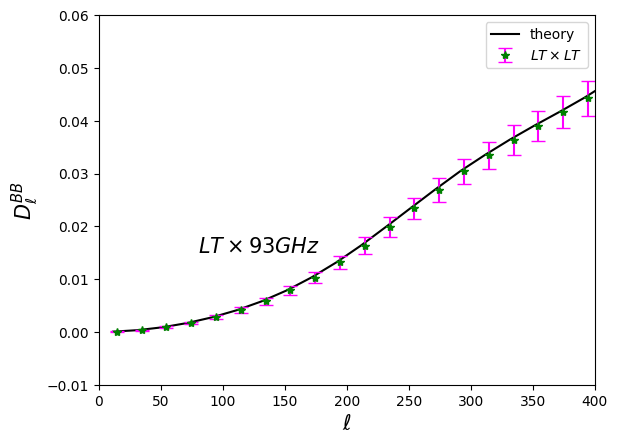

In [7]:
ell_eff = np.array([11.5,  31.5,  51.5,  71.5,  91.5, 111.5, 131.5, 151.5, 171.5, 191.5, 211.5, 231.5,
 251.5, 271.5, 291.5, 311.5, 331.5, 351.5, 371.5, 391.5, 411.5, 431.5, 451.5, 471.5,
 491.5, 511.5, 531.5, 551.5, 571.5, 591.5, 611.5, 631.5, 651.5, 671.5, 691.5, 711.5,
 731.5, 751.5, 771.5, 791.5, 811.5, 831.5, 851.5, 871.5, 891.5, 911.5, 931.5, 951.5,
 971.5,])

plt.plot(ell_eff, (dlbb_LT_LT_mean[5]),color = 'k',label = 'theory')

i=93

plt.errorbar(ell_eff+3, dlbb_LT_LT, yerr=dlbb_LT_LT_std, fmt='g*', ecolor='magenta', capsize=5, label=fr'$LT \times LT $')

#plt.errorbar(ell_eff, dlbb_obs_LT_debias_mean[i], yerr=dlbb_obs_LT_debias_std[i], fmt='r^', ecolor='blue', capsize=5, label=fr'$LT \times {i}GHz$',)

plt.xlim(0,400)
plt.ylim(-0.01,0.06)
plt.legend()
plt.xlabel('$\ell$',fontsize=15)
plt.ylabel('$D_{\ell}^{BB}$',fontsize=15)
plt.text(80,0.015,fr'$LT \times {i}GHz$',fontsize=15)

In [8]:
np.savetxt('./LT_LT_debias_mean.txt', dlbb_LT_LT)
np.savetxt('./LT_LT_debias_std.txt', dlbb_LT_LT_std)

In [45]:
np.shape(dlbb_LT_LT)

(49,)

## 然后，关于LT*obs

In [9]:
#第一遍平均，得到bias项和transfer function
import os
import pickle
import numpy as np

# 存储累加值的字典
sum_dict = {}

# 存储pickle文件的数量
num_files = 0

# 遍历所有的pickle文件
for filename in os.listdir('./LT_obs'):
    if filename.endswith('.pickle'):
        num_files += 1

        with open(os.path.join('./LT_obs', filename), 'rb') as f:
            data = pickle.load(f)
            # 遍历字典并累加值
            for key, value_list in data.items():
                if key not in sum_dict:
                    sum_dict[key] = [np.zeros_like(value) for value in value_list]
                for i, value in enumerate(value_list):
                    sum_dict[key][i] += value
    #if num_files == 200:
        #break

# 计算平均值
dlbb_obs_LT = {key: [value / num_files for value in value_list] for key, value_list in sum_dict.items()}

In [10]:
with open('./LT_obs_average.pkl', 'wb') as f:
    pickle.dump(dlbb_obs_LT, f)

In [11]:
#第二遍平均，得到debiased的LT_obs文件
import os
import pickle
import numpy as np

# 存储累加值的字典
sum_dict = {}
debias = {}
# 存储pickle文件的数量
num_files = 0

# 遍历所有的pickle文件
for filename in os.listdir('./LT_obs'):
    if filename.endswith('.pickle'):
        num_files += 1

        with open(os.path.join('./LT_obs', filename), 'rb') as f:
            data = pickle.load(f)
            # 遍历字典并累加值
            for key, value_list in data.items():
                if key not in sum_dict:
                    sum_dict[key] = [np.zeros_like(value_list[0])]
                debias[key] = (value_list[1] - dlbb_obs_LT[key][2] - dlbb_obs_LT[key][3]) / dlbb_obs_LT[key][4]
                sum_dict[key] += debias[key]
    #if num_files == 200:
        #break        


# 计算平均值
dlbb_obs_LT_debias_mean = {key: [value / num_files for value in value_list][0] for key, value_list in sum_dict.items()}

# 存储平方差累加值的字典
squared_diff_sum_dict = {key: np.zeros_like(value) for key, value in sum_dict.items()}

# 输出平均后的字典
print(dlbb_obs_LT_debias_mean[27])


[ 5.36066952e-05  3.30086037e-04  9.16400141e-04  1.64729181e-03
  2.70031097e-03  4.23895692e-03  5.87428682e-03  7.89839012e-03
  1.02866614e-02  1.32703524e-02  1.33422723e-02 -4.14418278e-01
 -5.34246617e-01  4.71081687e-01  5.41597799e-01  5.10502107e+00
  1.87368542e+00 -6.15414721e+00 -2.13716179e+01  2.66131530e+00
  1.61019818e+01 -6.12404811e+00  5.49836936e+00 -2.10428960e+01
 -1.56407977e+01 -1.46741515e+01 -1.41563432e+01 -2.27654467e+01
  2.29613911e+02 -9.34159642e+00 -3.68656847e+01  9.85893555e+01
  4.76858505e+01 -1.01665513e+01  1.45423600e+01 -5.25937729e+00
  7.68669240e+01 -2.18281161e+01 -8.90498147e+00 -1.03721653e+01
 -1.23070494e+01  4.15075726e+01  6.39979940e+01  4.04019880e+01
  8.65368819e+01 -2.94274662e+01 -8.99144401e+00 -1.45897406e+01
 -2.58376268e+02]


In [12]:
# 第三次遍历所有的pickle文件，计算每个文件中debias与平均值的平方差的累加值
debias = {}
squared_diff = {}
for filename in os.listdir('./LT_obs'):
    if filename.endswith('.pickle'):
        with open(os.path.join('./LT_obs', filename), 'rb') as f:
            data = pickle.load(f)
            for key, value_list in data.items():
                debias[key] = (value_list[1] - dlbb_obs_LT[key][2] - dlbb_obs_LT[key][3]) / dlbb_obs_LT[key][4]
                squared_diff[key] = (debias[key] - dlbb_obs_LT_debias_mean[key]) ** 2
                squared_diff_sum_dict[key] += squared_diff[key]
    #if num_files == 200:
            #break

# 计算debias的标准差
dlbb_obs_LT_debias_std = {key: np.sqrt(value / num_files) for key, value in squared_diff_sum_dict.items()}

In [13]:
with open('./LT_obs_debias_average.pkl', 'wb') as f:
    pickle.dump(dlbb_obs_LT_debias_mean, f)
with open('./LT_obs_debias_std.pkl', 'wb') as f:
    pickle.dump(dlbb_obs_LT_debias_std, f)

Text(80, 0.015, '$LT \\times 280GHz$')

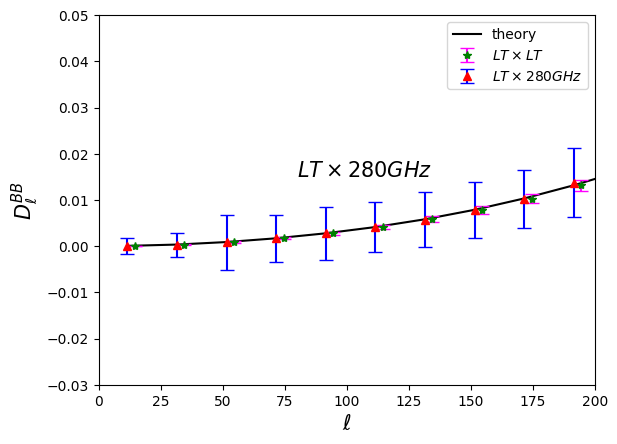

In [20]:
ell_eff = np.array([11.5,  31.5,  51.5,  71.5,  91.5, 111.5, 131.5, 151.5, 171.5, 191.5, 211.5, 231.5,
 251.5, 271.5, 291.5, 311.5, 331.5, 351.5, 371.5, 391.5, 411.5, 431.5, 451.5, 471.5,
 491.5, 511.5, 531.5, 551.5, 571.5, 591.5, 611.5, 631.5, 651.5, 671.5, 691.5, 711.5,
 731.5, 751.5, 771.5, 791.5, 811.5, 831.5, 851.5, 871.5, 891.5, 911.5, 931.5, 951.5,
 971.5,])

plt.plot(ell_eff, (dlbb_LT_LT_mean[5]),color = 'k',label = 'theory')

i=280

plt.errorbar(ell_eff+3, dlbb_LT_LT, yerr=dlbb_LT_LT_std, fmt='g*', ecolor='magenta', capsize=5, label=fr'$LT \times LT $')

plt.errorbar(ell_eff, dlbb_obs_LT_debias_mean[i], yerr=dlbb_obs_LT_debias_std[i], fmt='r^', ecolor='blue', capsize=5, label=fr'$LT \times {i}GHz$',)

plt.xlim(0,200)
plt.ylim(-0.03,0.05)
plt.legend()
plt.xlabel('$\ell$',fontsize=15)
plt.ylabel('$D_{\ell}^{BB}$',fontsize=15)
plt.text(80,0.015,fr'$LT \times {i}GHz$',fontsize=15)

## 最后，关于obs*obs, noise, FG

In [21]:
import os
import pickle
import numpy as np

# 存储累加值的字典
sum_dict = {}

# 存储pickle文件的数量
num_files = 0

# 遍历所有的pickle文件
for filename in os.listdir('./obs_obs'):
    if filename.endswith('.pickle'):
        num_files += 1
        with open(os.path.join('./obs_obs', filename), 'rb') as f:
            data = pickle.load(f)
            # 遍历字典并累加值
            for key, value_list in data.items():
                if key not in sum_dict:
                    sum_dict[key] = [np.zeros_like(value) for value in value_list]
                for i, value in enumerate(value_list):
                    sum_dict[key][i] += value

# 计算平均值
dlbb_obs_obs = {key: [value / num_files for value in value_list] for key, value_list in sum_dict.items()}

# 输出平均后的字典
#print(dlbb_obs_obs)


In [22]:
import os
import pickle
import numpy as np

# 存储累加值的字典
sum_dict = {}

# 存储pickle文件的数量
num_files = 0

# 遍历所有的pickle文件
for filename in os.listdir('./noise&FG'):
    if filename.endswith('.pickle'):
        num_files += 1
        with open(os.path.join('./noise&FG', filename), 'rb') as f:
            data = pickle.load(f)
            # 遍历字典并累加值
            for key, value_list in data.items():
                if key not in sum_dict:
                    sum_dict[key] = [np.zeros_like(value) for value in value_list]
                for i, value in enumerate(value_list):
                    sum_dict[key][i] += value

# 计算平均值
dlbb_noise = {key: [value / num_files for value in value_list] for key, value_list in sum_dict.items()}

# 输出平均后的字典
#print(dlbb_noise)


In [23]:
import os
import pickle
import numpy as np

# 存储累加值的字典
sum_dict = {}

# 存储pickle文件的数量
num_files = 0

# 遍历所有的pickle文件
for filename in os.listdir('./FG_only'):
    if filename.endswith('.pickle'):
        num_files += 1
        with open(os.path.join('./FG_only', filename), 'rb') as f:
            data = pickle.load(f)
            # 遍历字典并累加值
            for key, value_list in data.items():
                if key not in sum_dict:
                    sum_dict[key] = [np.zeros_like(value) for value in value_list]
                for i, value in enumerate(value_list):
                    sum_dict[key][i] += value

# 计算平均值
dlbb_FG = {key: [value / num_files for value in value_list] for key, value_list in sum_dict.items()}

# 输出平均后的字典
#print(dlbb_FG)


In [24]:
with open('./dlbb_noise_average.pkl', 'wb') as f:
    pickle.dump(dlbb_noise, f)

In [25]:
with open('./obs_obs_average.pkl', 'wb') as f:
    pickle.dump(dlbb_obs_obs, f)

In [26]:
with open('./dlbb_FG_average.pkl', 'wb') as f:
    pickle.dump(dlbb_FG, f)

/tmp/ipykernel_15349/2415874769.py:11: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,300)
/tmp/ipykernel_15349/2415874769.py:12: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e3)


(3.2351519445660004e-05, 1000.0)

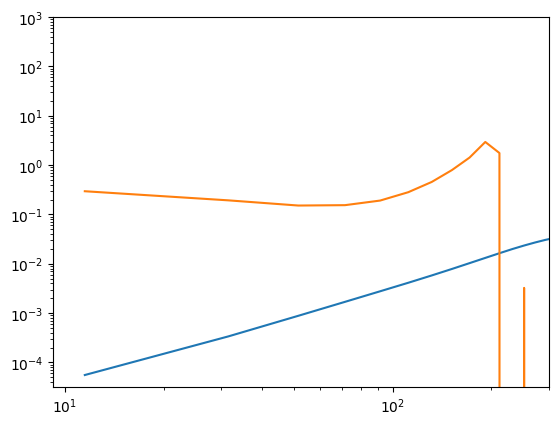

In [27]:
ell_eff = [11.5,  31.5,  51.5,  71.5,  91.5, 111.5, 131.5, 151.5, 171.5, 191.5, 211.5, 231.5,
 251.5, 271.5, 291.5, 311.5, 331.5, 351.5, 371.5, 391.5, 411.5, 431.5, 451.5, 471.5,
 491.5, 511.5, 531.5, 551.5, 571.5, 591.5, 611.5, 631.5, 651.5, 671.5, 691.5, 711.5,
 731.5, 751.5, 771.5, 791.5, 811.5, 831.5, 851.5, 871.5, 891.5, 911.5, 931.5, 951.5,
 971.5,]


plt.loglog(ell_eff, (dlbb_LT_LT_mean[5]))
plt.loglog(ell_eff, (dlbb_obs_obs[(39,39)]))

plt.xlim(0,300)
plt.ylim(0,1e3)

# 计算Cl*Cl平均值

### <Cl * Cl>

In [28]:
import os
import pickle
import numpy as np

dlbb_LT_LT_average = np.loadtxt('./LT_LT_mean.txt')  #l_bin, dlbb_temp_noisy, dlbb_temp_noise, dlbb_pure, dlbb_len_bin, transfer_temp

with open(os.path.join('./LT_obs_average.pkl'), 'rb') as f:  #dlbb_cross_pure, dlbb_cross, dlbb_cross_noise1, dlbb_cross_noise2, transfer_temp_cross, dlbb_cross_fg_temp
    dlbb_LT_obs_average = pickle.load(f)

with open(os.path.join('./obs_obs_average.pkl'), 'rb') as f:  
    dlbb_obs_obs_average = pickle.load(f)

suffix_range = range(500)
total_clcls = np.zeros((49, 28, 28))

suffix_lost = [214,215,314,315]
suffix_range = [suffix for suffix in suffix_range if suffix not in suffix_lost]

for suffix in suffix_range:
    data_vec = []

    #LT_LT
    filename1 = os.path.join('./LT_LT', f'dlbb_LT_LT_{suffix}.txt')
    data_LT = ((np.loadtxt(filename1))[1] - dlbb_LT_LT_average[2] - 2*dlbb_LT_LT_average[4]) / dlbb_LT_LT_average[6]

    #LT_obs
    data_cross = {}
    filename2 = os.path.join('./LT_obs', f'dlbb_obs_LT_{suffix}.pickle')
    with open(filename2, 'rb') as f:
        dlbb_LT_obses = pickle.load(f)
    for i,data in dlbb_LT_obses.items():
        data_cross[i] = (data[1]-dlbb_LT_obs_average[i][2]-dlbb_LT_obs_average[i][3])/dlbb_LT_obs_average[i][4]
        #data_cross[i] = (data[1]-data[2]-data[3])/data[4]
    
    #obs_obs
    data_obs = {}
    filename3 = os.path.join('./obs_obs', f'dlbb_obs_obs_{suffix}.pickle')    
    with open(filename3, 'rb') as f:
        dlbb_obs_obs = pickle.load(f)
    for i,data in dlbb_obs_obs.items():
        data_obs[i] = data

    
    # Used for Gaussian likelihood function
    data_vec = np.array([data_obs[(27,27)],data_obs[(27,39)],data_obs[(27,93)],data_obs[(27,145)],data_obs[(27,225)],data_obs[(27,280)],data_cross[27],
                data_obs[(39,39)],data_obs[(39,93)],data_obs[(39,145)],data_obs[(39,225)],data_obs[(39,280)],data_cross[39],
                data_obs[(93,93)],data_obs[(93,145)],data_obs[(93,225)],data_obs[(93,280)],data_cross[93],
                data_obs[(145,145)],data_obs[(145,225)],data_obs[(145,280)],data_cross[145],
                data_obs[(225,225)],data_obs[(225,280)],data_cross[225],
                data_obs[(280,280)],data_cross[280],
                data_LT])
    np.savetxt(f'./data_vec/data_vec_{suffix}.txt', data_vec)
    """
    
    # Used for HL likelihood function
    data_vec = np.array([data_obs[(27,27)],
                         data_obs[(27,39)], data_obs[(39,39)],
                         data_obs[(27,93)],data_obs[(39,93)],data_obs[(93,93)],
                         data_obs[(27,145)],data_obs[(39,145)],data_obs[(93,145)],data_obs[(145,145)],
                         data_obs[(27,225)],data_obs[(39,225)],data_obs[(93,225)],data_obs[(145,225)],data_obs[(225,225)],
                         data_obs[(27,280)],data_obs[(39,280)],data_obs[(93,280)],data_obs[(145,280)],data_obs[(225,280)],data_obs[(280,280)],
                         data_cross[27], data_cross[39], data_cross[93], data_cross[145], data_cross[225], data_cross[280],data_LT])

    np.savetxt(f'./data_vec_HL/data_vec_{suffix}.txt', data_vec)
    """

    
    clcls = []
    for l in range(49):
       
        clcl = np.outer(data_vec[:,l], data_vec[:,l])
        clcls.append(clcl)
    total_clcls += clcls
clcl_average = total_clcls / len(suffix_range)



###  < Cl > * < Cl >

In [29]:
# 计算平均值
data_vec_average_fit,_ = plot_mean_with_error_bars_from_directory_txt('./data_vec', 1000)

cl_a_cl_as = []
for l in range(49):
    cl_a_cl_a = np.outer(data_vec_average_fit[:,l], data_vec_average_fit[:,l])
    cl_a_cl_as.append(cl_a_cl_a)

# 输出平均后的字典
#print(data_vec_average_fit)

#print(data_vec_average)
np.savetxt(f'./data_vec_fit_average.txt', data_vec_average_fit)

(-0.01, 0.02)

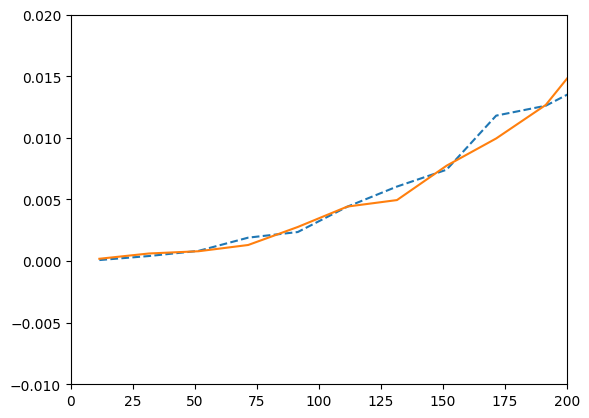

In [30]:
with open(os.path.join('./LT_obs_average.pkl'), 'rb') as f:  #dlbb_cross_pure, dlbb_cross, dlbb_cross_noise1, dlbb_cross_noise2, transfer_temp_cross, dlbb_cross_fg_temp
    dlbb_LT_obs_average = pickle.load(f)

filename2 = os.path.join('./LT_obs/dlbb_obs_LT_37.pickle')
with open(filename2, 'rb') as f:
        dlbb_data = pickle.load(f)
plt.plot(ell_eff,data_LT,"--",)
plt.plot(ell_eff, (dlbb_data[93][1]-dlbb_LT_obs_average[93][2]-dlbb_LT_obs_average[93][3])/dlbb_LT_obs_average[93][4])      #-dlbb_data[27][2]-dlbb_data[27][3]

plt.xlim(0,200)
plt.ylim(-0.01,0.02)

### 现在，计算Cov matrix

In [31]:
COV_matrix = np.array(clcl_average)-np.array(cl_a_cl_as)

In [32]:
np.save('./COV_matrix.npy', COV_matrix)
loaded_array = np.load('./COV_matrix.npy')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

# Step 1: 读取文件
file_path = '/root/Testarea/prototype/Foreground/post_cal4/cobaya_output.1.txt'

with open(file_path, 'r') as file:
    lines = file.readlines()

# Step 2: 解析数据
r_values = []
for line in lines:
    if line.strip() and not line.startswith("#"):
        parts = line.split()
        try:
            r_value = float(parts[4])  # 第3列是r的值
            r_values.append(r_value)
        except ValueError:
            # 跳过无法解析的行
            continue

# Step 3: 绘制直方图
plt.hist(r_values, bins=50, edgecolor='black', density=True, alpha=0.6, color='g')

# Step 4: 拟合曲线
r_values_np = np.array(r_values)
kde = gaussian_kde(r_values_np)
r_range = np.linspace(min(r_values), max(r_values), 1000)
kde_values = kde(r_range)

plt.plot(r_range, kde_values, color='r', label='Fit Curve')

plt.xlabel('r Value')
plt.ylabel('Density')
plt.title('Histogram and Fit Curve of Parameter r')
plt.legend()
plt.grid(True)
plt.show()



In [33]:
def plot_matrix_with_log(matrix, cmap='viridis', title='2D Matrix Visualization with Logarithmic Values and Grid'):
    """
    绘制带有取对数值和网格线的二维矩阵。
    
    参数:
    matrix (np.array): 输入的二维矩阵。
    cmap (str): 颜色映射方案。默认值为 'viridis'。
    title (str): 图像标题。默认值为 '2D Matrix Visualization with Logarithmic Values and Grid'。
    """
    
    # 对矩阵中的每个元素取自然对数
    log_matrix = np.log(matrix)
    
    # 使用 Matplotlib 绘制取对数后的矩阵
    fig, ax = plt.subplots()
    cax = ax.matshow(log_matrix, cmap=cmap)
    
    # 添加颜色条
    fig.colorbar(cax)
    
    # 在每个格子中显示取对数后的数值
    rows, cols = log_matrix.shape
    #for i in range(rows):
    #    for j in range(cols):
    #        ax.text(j, i, f'{log_matrix[i, j]:.2f}', ha='center', va='center', color='white')
    
    # 添加内线
    ax.set_xticks(np.arange(-0.5, cols, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, rows, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=2)
    
    # 隐藏主刻度线
    ax.tick_params(which='major', bottom=False, left=False)
    
    # 添加标题
    plt.title(title)
    
    # 显示图像
    plt.show()

/tmp/ipykernel_15349/2013911822.py:12: RuntimeWarning: invalid value encountered in log
  log_matrix = np.log(matrix)


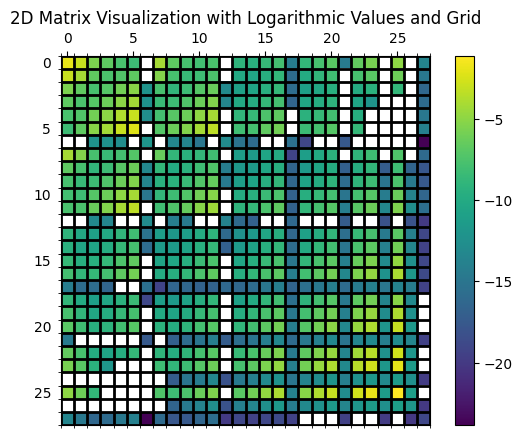

In [34]:
plot_matrix_with_log(np.array(clcl_average)[1,:,:]-np.array(cl_a_cl_as)[1,:,:])

In [35]:
np.shape(cl_a_cl_as)

(49, 28, 28)